# El código implementado aquí está basado en el notebook de python de Greg Hogg para la predicción de series temporales
El notebook se lo puede encontrar en la siguiente dirección:
https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing

Mientras que los vídeos explicativos de su implementación se encuentran aquí:
https://www.youtube.com/watch?v=c0k-YLQGKjY

De todos los modelos que intenté (incluido el método de wavelets) los inspirados en este material fueron los que dieron mejores resultados. En la programación añadí la posibilidad de predecir variables no solo dentro de la siguiente hora, sino dentro de varias horas especificadas por el usuario.

# Importar

In [ ]:
# Para la generar la red neuronal que vamos a entrenar uso la biblioteca Tensorflow. En este notebook utilizo redes neuronales recurrentes para predecir
# todas las propiedades climatológicas Temp_AVG, Temp_MIN, Hum_R, Vel_V, CLDALTAS, CLDBAJAS, CLDMED, y PRECIP para la doceava hora, usando los valores
# de estas variables en las primeras 6 horas.
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


# Cargamos y miramos el dataframe

In [ ]:
df = pd.read_excel('/content/datos.xlsx')

In [ ]:
df

,date,hour,Time,Temp_AVG,Temp_MIN,Hum_R,Vel_V,CLDALTAS,CLDBAJAS,CLDMED,PRECIP
0,2014-01-01,00:00:00,2014-01-01 00:00:00,7.2,6.0,92.5,4.4,0.001329,0.521484,0.173950,0.19
1,2014-01-01,01:00:00,2014-01-01 01:00:00,6.9,6.1,84.4,3.5,0.000998,0.531006,0.150635,0.14
2,2014-01-01,02:00:00,2014-01-01 02:00:00,6.3,5.0,89.0,3.8,0.000819,0.535156,0.109253,0.12
3,2014-01-01,03:00:00,2014-01-01 03:00:00,6.0,5.4,87.6,3.2,0.001554,0.493164,0.128784,0.14
4,2014-01-01,04:00:00,2014-01-01 04:00:00,4.9,3.6,95.4,3.3,0.000662,0.491455,0.179321,0.18
...,...,...,...,...,...,...,...,...,...,...,...
78883,2022-12-31,19:00:09,2022-12-31 19:00:09,9.3,9.3,80.9,2.9,0.803223,0.272583,0.522705,0.03
78884,2022-12-31,20:00:09,2022-12-31 20:00:09,8.6,8.6,93.3,1.7,0.784668,0.319580,0.494751,0.04
78885,2022-12-31,21:00:09,2022-12-31 21:00:09,8.1,8.1,99.6,1.2,0.841309,0.554688,0.488281,0.06
78886,2022-12-31,22:00:09,2022-12-31 22:00:09,7.7,7.6,99.8,1.4,0.790283,0.617676,0.514893,0.09


# Arreglamos el dataframe para que solo consten variables relevantes

In [ ]:
df.index = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
df=df.drop(columns=['date','hour', 'Time'])
df

,Temp_AVG,Temp_MIN,Hum_R,Vel_V,CLDALTAS,CLDBAJAS,CLDMED,PRECIP
Time,,,,,,,,
2014-01-01 00:00:00,7.2,6.0,92.5,4.4,0.001329,0.521484,0.173950,0.19
2014-01-01 01:00:00,6.9,6.1,84.4,3.5,0.000998,0.531006,0.150635,0.14
2014-01-01 02:00:00,6.3,5.0,89.0,3.8,0.000819,0.535156,0.109253,0.12
2014-01-01 03:00:00,6.0,5.4,87.6,3.2,0.001554,0.493164,0.128784,0.14
2014-01-01 04:00:00,4.9,3.6,95.4,3.3,0.000662,0.491455,0.179321,0.18
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:09,9.3,9.3,80.9,2.9,0.803223,0.272583,0.522705,0.03
2022-12-31 20:00:09,8.6,8.6,93.3,1.7,0.784668,0.319580,0.494751,0.04
2022-12-31 21:00:09,8.1,8.1,99.6,1.2,0.841309,0.554688,0.488281,0.06


<Axes: xlabel='Time'>

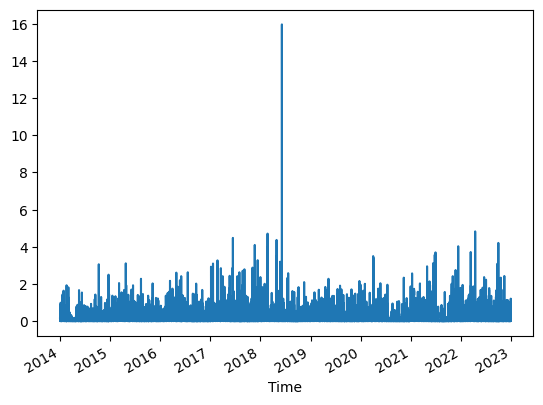

In [ ]:
precip = df['PRECIP']
precip.plot()

# Organización de datos de entrada y de salida

In [ ]:
# La función df_to_X_y toma del dataframe df un numero de filas igual a 'ventana' (por defecto 6) y como datos de salida toma la fila=ventana+r+1.
# De esta manera el modelo se entrena tomando los valores de Temp_AVG, Temp_MIN, Hum_R, Vel_V, CLDALTAS, CLDBAJAS, CLDMED, y PRECIP para 6 horas
# consecutivos--estos son nuestros datos predictores--, y el valor de Precipitación (la septima columna contando desde cero) para una hora=ventana+r+1.
# Ahora, si se desea predecir el valor de alguna otra propiedad basta con cambiar el valor 7 que por defecto
# tiene n por el numero de columna (contando desde cero) de la propiedad que queremos predecir para la hora=ventana+r+1 hora. También es posible modificar
# la ventana de horas que se usarán para los datos de entrada. De manera que si pusieramos 2 en dicha ventana, se considerarán como datos de entrada
# los valores de todas las propiedades para las dos primeras horas. Finalmente, r (que por defecto lo puse en 0) es un numero de horas posteriores a
# las que se indica en la ventana para las cuáles me gustaría tener la predicción. De manera que por defecto, el modelo1 toma como de entrada los
# datos climatológicos correspondientes a las 6 primeras horas, y nos devuelve el dato de precipitación de la septima hora.

def df_to_X_y(df, ventana=6, n=7, r=0):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-ventana-r):
    row = [r for r in df_as_np[i:i+ventana]]
    X.append(row)
    label = df_as_np[i+ventana+r][n]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X, y = df_to_X_y(df,6,7,0)
X.shape, y.shape

((78882, 6, 8), (78882,))

# Partición de datos en datos de entramiento, validación y prueba

In [ ]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 6, 8), (60000,), (5000, 6, 8), (5000,), (13882, 6, 8), (13882,))

# Primer modelo usando Long Short-Term Memory (LSTM):
Este modelo usa todos los datos climatológicos durante 6 horas y predice la
precipitación para la siguiente hora (la septima).   


In [ ]:
# Esta es una red neuronal recurrente que usa secuencias, en particular series temporales. Como se puede notar la capa de entrada toma 8 variables
# (columnas del df) para las primeras 6 horas. En este caso la celda LSTM tiene dimensión 64, además este modelo tiene una capa oculta de 8 neuronas
# (variables) las cuales toman los valores que resultan de combinaciones lineales realizadas sobre los datos de la capa anterior (en este caso la de entrada).
# Dichos valores son procesados por una función no lineal conocida como relu que es casí como una función escalón (esto para simular la transmisión eléctrica
# en la sinapsis neuronal). La capa de salida tiene 1 valor correspondiente a los valores de precipitación para la 12 ava hora.
model1 = Sequential()
model1.add(InputLayer((6, 8)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18688     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19217 (75.07 KB)
Trainable params: 19217 (75.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# La red neuronal aprende minimizando el error (función escalar) que hay entre los datos reales para la 12 ava hora, y las predicciones hechas para esa
# hora. Las predicciones serían los valores que resultan de tomar los datos de entrada (primera capa) ingresarlos a una combinación lineal, para luego
# tomar los resultados e ingresarlos a funciones no lineales (capas intermedias u ocultas). Para esta minimización se suele usar el gradiente
# (el cual nos indicaría la dirección de la máxima variación de la función escalar 'error') o variaciones del gradiente. La tasa de aprendizaje
# viene a ser la longitud del vector gradiente que en este caso la tomé igual a 0.0001. En este caso la función error corresponde al error cuadrático medio.
# Una vez creado el modelo en el paso anterior, lo vamos a compilar con las especificaciones mencionadas.
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
# En este paso vamos a entrenar el modelo ajustandolo a los datos de entrenamiento. Vamos a correr el modelo 10 veces (épocas), cada vez que corre el
# modelo genera una predicción para las 8 propiedades, y aprende minimizando el error.
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
1875/1875 [==============================] - 18s 8ms/step - loss: 0.0734 - root_mean_squared_error: 0.2710 - val_loss: 0.0609 - val_root_mean_squared_error: 0.2469
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0305 - root_mean_squared_error: 0.1745 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1676
Epoch 3/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0213 - root_mean_squared_error: 0.1460 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val

# Graficas y comparación de predicciones versus los datos reales (Modelo 1)


434/434 [==============================] - 2s 3ms/step


(       Predictions  Actuals
 0         0.137469     0.00
 1         0.063102     0.00
 2         0.070267     0.00
 3         0.038519     0.00
 4         0.063348     0.00
 ...            ...      ...
 13877    -0.068345     0.03
 13878     0.057372     0.04
 13879     0.037685     0.06
 13880     0.079269     0.09
 13881     0.114226     0.11
 
 [13882 rows x 2 columns],
 0.025026824758442014)

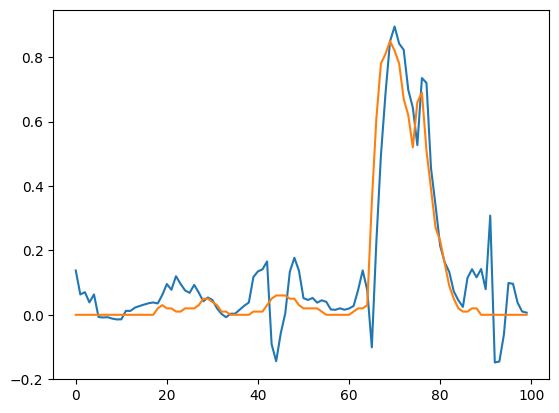

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)
plot_predictions1(model1, X_test, y_test)

# Modelo1 para predecir precipitación luego de 6 horas

In [ ]:
df_to_X_y(df,6,7,5)
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])


Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val

# Graficos de precipitación dentro de 6 horas (Modelo 1)

434/434 [==============================] - 1s 3ms/step


(       Predictions  Actuals
 0         0.113742     0.00
 1         0.048763     0.00
 2         0.069278     0.00
 3         0.050244     0.00
 4         0.080549     0.00
 ...            ...      ...
 13877    -0.019042     0.03
 13878     0.040077     0.04
 13879     0.035800     0.06
 13880     0.063919     0.09
 13881     0.097453     0.11
 
 [13882 rows x 2 columns],
 0.0253934404704287)

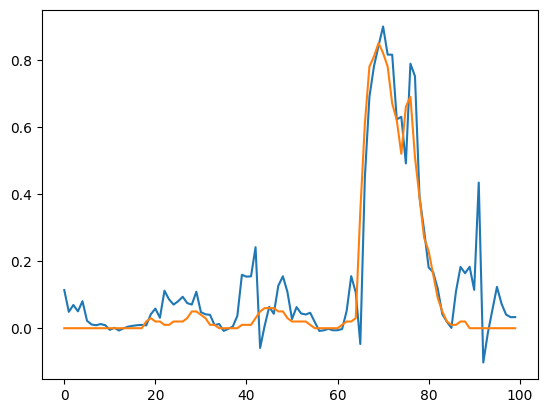

In [ ]:
plot_predictions1(model1, X_test, y_test)

# Segundo Modelo usando convolución para predecir precipitación dentro de 6 horas

In [ ]:
model2 = Sequential()
model2.add(InputLayer((6, 8)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             1088      
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                 2568      
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3665 (14.32 KB)
Trainable params: 3665 (14.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp2])

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2086 - root_mean_squared_error: 0.4568 - val_loss: 0.6887 - val_root_mean_squared_error: 0.8299
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.4403 - val_root_mean_squared_error: 0.6636
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0517 - root_mean_squared_error: 0.2275 - val_loss: 0.2920 - val_root_mean_squared_error: 0.5404
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0415 - root_mean_squared_error: 0.2037 - val_loss: 0.2118 - val_root_mean_squared_error: 0.4602
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.1807 - val_root_mean_squared_error: 0.4251
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0297 - root_mean_squared_error: 0.1722 - val_loss: 0

# Graficas y comparación de predicciones versus los datos reales dentro de 6 horas (Modelo 2)

434/434 [==============================] - 1s 2ms/step


(       Predictions  Actuals
 0         0.034235     0.00
 1         0.084030     0.00
 2         0.087381     0.00
 3         0.047686     0.00
 4         0.017847     0.00
 ...            ...      ...
 13877    -0.422514     0.03
 13878     0.049547     0.04
 13879     0.080921     0.06
 13880     0.092935     0.09
 13881     0.105184     0.11
 
 [13882 rows x 2 columns],
 0.5084246873420093)

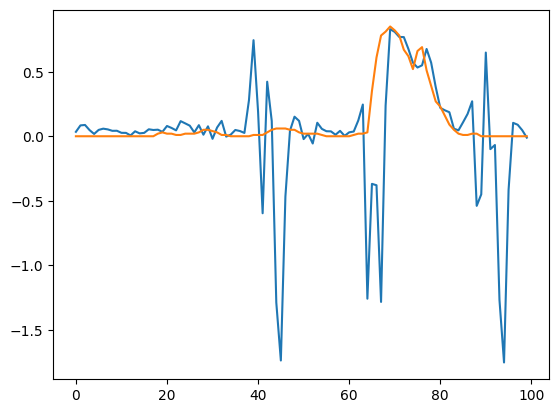

In [ ]:
plot_predictions1(model2, X_test, y_test)

# Modelo 3 para predecir precipitación y temperatura media dentro de tres horas con LSTM y datos normalizados

In [ ]:
# La función df_to_X_y3 funciona igual que la df_to_X_y con la diferencia en la df_to_X_y2 los datos de salida (por defecto) corresponden a
# temperatura media (n=columna 0) y precipitación (m=columna 7). Aquí se usa una ventana de 6 horas para conocer precipitación y temperatura medias
# dentro de las r=2 horas siguientes. Para cambiar las variables a predecir basta cambiar los numeros de columna n y m de las nuevas variables a predecir.
# De igual forma al cambiar el valor de r se modifica el numero de horas dentro de las cuales se hará la predicción.

def df_to_X_y3(df, ventana=6, n = 0, m = 7, r = 2):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-ventana-r):
    row = [r for r in df_as_np[i:i+ventana]]
    X.append(row)
    label = [df_as_np[i+ventana+r][n], df_as_np[i+ventana+r][m]]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X3, y3 = df_to_X_y3(df,6,0,7,2)
X3.shape, y3.shape

((78880, 6, 8), (78880, 2))

In [ ]:
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((60000, 6, 8), (60000, 2), (5000, 6, 8), (5000, 2), (13880, 6, 8), (13880, 2))

In [ ]:
# Las siguientes funciones preprocess3 y preprocess_output normalizan los datos de entrada X y los de saida y
p_training_mean3 = np.mean(X3_train[:, :, 0])
p_training_std3 = np.std(X3_train[:, :, 0])

temp_training_mean3 = np.mean(X3_train[:, :, 1])
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X):
  X[:, :, 0] = (X[:, :, 0] - p_training_mean3) / p_training_std3
  X[:, :, 1] = (X[:, :, 1] - temp_training_mean3) / temp_training_std3
  return X

def preprocess_output(y):
  y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
  y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
  return y

In [ ]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

In [ ]:
model3 = Sequential()
model3.add(InputLayer((6, 8)))
model3.add(LSTM(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(2, 'linear'))

model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                18688     
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 2)                 18        
                                                                 
Total params: 19226 (75.10 KB)
Trainable params: 19226 (75.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp3])

Epoch 1/10
1875/1875 [==============================] - 20s 9ms/step - loss: 13.2491 - root_mean_squared_error: 3.6399 - val_loss: 8.2966 - val_root_mean_squared_error: 2.8804
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 2.4578 - root_mean_squared_error: 1.5677 - val_loss: 4.7309 - val_root_mean_squared_error: 2.1751
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 1.6421 - root_mean_squared_error: 1.2814 - val_loss: 3.5116 - val_root_mean_squared_error: 1.8739
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 1.4323 - root_mean_squared_error: 1.1968 - val_loss: 3.4766 - val_root_mean_squared_error: 1.8646
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 1.3563 - root_mean_squared_error: 1.1646 - val_loss: 3.1773 - val_root_mean_squared_error: 1.7825
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 1.3154 - root_mean_squared_error: 1.1469 - val

In [ ]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  temp_preds, p_preds = predictions[:, 0], predictions[:, 1]
  temp_actual, p_actual = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperatura_m Predicción': temp_preds,
                          'Temperatura_m Actual':temp_actual,
                          'Precipitación Predicción': p_preds,
                          'Precipitación Actual': p_actual
                          })
  plt.plot(df['Temperatura_m Predicción'][start:end])
  plt.plot(df['Temperatura_m Actual'][start:end])
  plt.plot(df['Precipitación Predicción'][start:end])
  plt.plot(df['Precipitación Actual'][start:end])
  return df, predictions

434/434 [==============================] - 1s 3ms/step


,Temperatura_m Predicción,Temperatura_m Actual,Precipitación Predicción,Precipitación Actual
0,13.134460,17.5,-0.010591,0.00
1,12.478637,17.5,0.126231,0.00
2,12.468505,15.8,0.113199,0.00
3,12.272161,14.1,0.162444,0.00
4,12.288071,12.8,0.160513,0.00
...,...,...,...,...
13875,9.318493,9.3,0.173612,0.03
13876,9.787560,8.6,0.215786,0.04
13877,8.570951,8.1,0.204422,0.06
13878,8.384565,7.7,0.146076,0.09


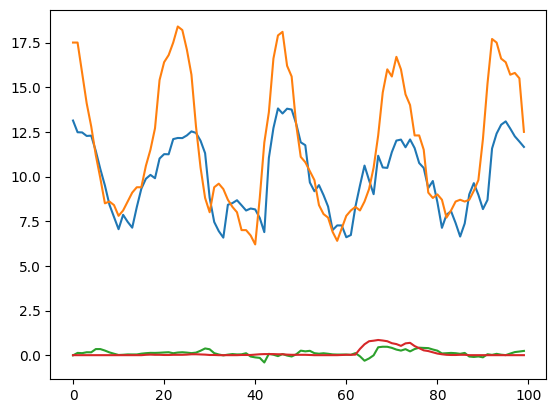

In [ ]:
# Graficas y comparaciones de las temperaturas y precipitaciones predichas dentro de tres horas con las variables reales para ese tiempo,
# usando datos normalizados
plot_predictions2(model3, X3_test, y3_test)

In [ ]:
# Las funciones postprocess y postprocess_p ayudan a "desnormalizar" los datos para tenerlos en la escala original

def postprocess_temp(arr):
  arr = (arr*temp_training_std3) + temp_training_mean3
  return arr

def postprocess_p(arr):
  arr = (arr*p_training_std3) + p_training_mean3
  return arr

In [ ]:
# get_predictions_postprocessed obtiene las temperaturas medias y precipitaciones predichas y reales en su escala original
def get_predictions_postprocessed(model, X, y):
  predictions = model.predict(X)
  p_preds, temp_preds = postprocess_p(predictions[:, 1]), postprocess_temp(predictions[:, 0])
  p_actuals, temp_actuals = postprocess_p(y[:, 1]), postprocess_temp(y[:, 0])
  df = pd.DataFrame(data={'Temperatura_m Predicción': temp_preds,
                          'Temperatura_m Actual':temp_actuals,
                          'Precipitación Predicción': p_preds,
                          'Precipitación Actual': p_actuals
                          })
  return df

In [ ]:
post_processed_df = get_predictions_postprocessed(model3, X3_test, y3_test)
post_processed_df

434/434 [==============================] - 1s 3ms/step


,Temperatura_m Predicción,Temperatura_m Actual,Precipitación Predicción,Precipitación Actual
0,41.291290,52.505252,8.116795,8.144499
1,39.606647,52.505252,8.474707,8.144499
2,39.580620,48.138384,8.440616,8.144499
3,39.076263,43.771517,8.569437,8.144499
4,39.117130,40.432148,8.564385,8.144499
...,...,...,...,...
13875,31.489042,31.441538,8.598652,8.222976
13876,32.693954,29.643416,8.708974,8.249135
13877,29.568798,28.359043,8.679248,8.301454
13878,29.090019,27.331545,8.526621,8.379931


# Graficas de comparación de la temperatura y precipitación predichas dentro de tres horas versus las reales usando el modelo 3

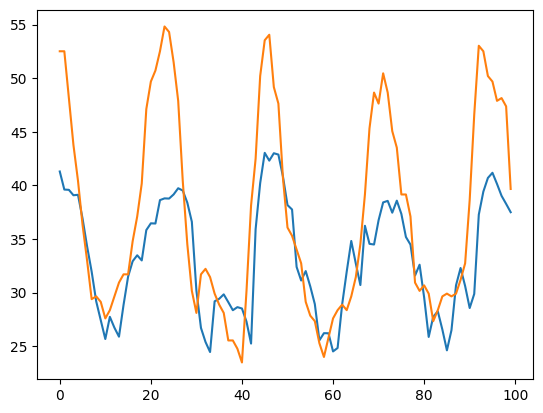

In [ ]:
start, end = 0, 100
plt.plot(post_processed_df['Temperatura_m Predicción'][start:end])
plt.plot(post_processed_df['Temperatura_m Actual'][start:end])

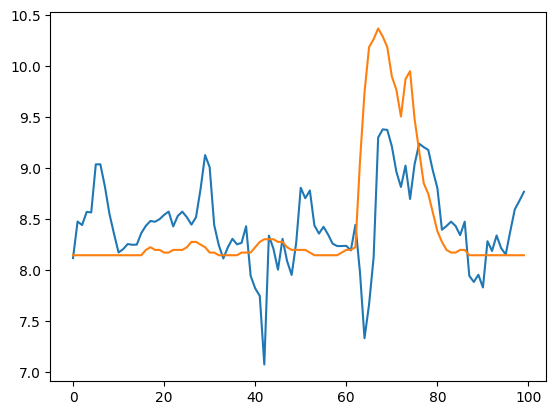

In [ ]:
plt.plot(post_processed_df['Precipitación Predicción'][start:end])
plt.plot(post_processed_df['Precipitación Actual'][start:end])

# Breve conclusión
Como se puede notar al ejecutar el notebook, todos los modelos demoran al rededor de tres minutos para ajustar el modelo durante 10 épocas. El modelo 1, donde partiendo de 6 horas de datos climatológicos obtenemos el datod de precipitación para la septima hora es el mas preciso. Sin embargo, sin perder mucha presición podemos constatar que el modelo 3 usado para predecir dentro de 3 horas la temperatura y la precipitación da buenos resultados.